# Feature Engineering

After cleaning the data in `cleaning.ipynb`, we need to group by CustomerID and generate some aggregate features to examine with clustering algorithms.

## Table of Contents
1. [Setup](#setup)
2. [Grouping & Feature Engineering](#grouping--feature-engineering)
3. [Data Exploration](#data-exploration)
4. [Outlier Extraction](#outlier-extraction)
5. [Scaling](#scaling)
6. [Export](#export)

## Setup

In [ ]:
#!pip install scikit-learn

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.useful_functions import load_clean_data
import datetime as dt
from sklearn.preprocessing import StandardScaler


In [21]:
transactions = load_clean_data().drop("Unnamed: 0", axis = 1)

In [106]:
transactions["TotalValue"] = transactions["UnitPrice"] * transactions["Quantity"]
transactions.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Grouping & Feature Engineering

In [107]:
#Group by CustomerID
transactions_by_customer = transactions.groupby("CustomerID", as_index=False)\
    .agg(
         LTDValue = ("TotalValue", "sum"),
         PurchaseFrequency = ("InvoiceNo", "nunique"),
         MostRecentPurchase = ("InvoiceDate", "max")
    )
    
transactions_by_customer.head(5)

,CustomerID,LTDValue,PurchaseFrequency,MostRecentPurchase
0,12346.0,77183.60,1,2011-01-18 10:01:00
1,12347.0,4310.00,7,2011-12-07 15:52:00
2,12348.0,1437.24,4,2011-09-25 13:13:00
3,12349.0,1457.55,1,2011-11-21 09:51:00
4,12350.0,294.40,1,2011-02-02 16:01:00


In [62]:
transactions_by_customer.dtypes



CustomerID            float64
LTDValue              float64
PurchaseFrequency       int64
MostRecentPurchase     object
dtype: object

In [63]:
transactions_by_customer["MostRecentPurchase"] = pd.to_datetime(transactions_by_customer["MostRecentPurchase"])
transactions_by_customer.dtypes

CustomerID                   float64
LTDValue                     float64
PurchaseFrequency              int64
MostRecentPurchase    datetime64[ns]
dtype: object

In [64]:
max_date = pd.to_datetime(transactions["InvoiceDate"].max())
max_date

Timestamp('2011-12-09 12:50:00')

In [65]:
transactions_by_customer["PurchaseRecencyDays"] = (max_date - transactions_by_customer["MostRecentPurchase"]).dt.days

In [66]:
transactions_by_customer.head(5)

,CustomerID,LTDValue,PurchaseFrequency,MostRecentPurchase,PurchaseRecencyDays
0,12346.0,77183.60,1,2011-01-18 10:01:00,325
1,12347.0,4310.00,7,2011-12-07 15:52:00,1
2,12348.0,1437.24,4,2011-09-25 13:13:00,74
3,12349.0,1457.55,1,2011-11-21 09:51:00,18
4,12350.0,294.40,1,2011-02-02 16:01:00,309


In [80]:
transactions_by_customer.describe()

,CustomerID,LTDValue,PurchaseFrequency,MostRecentPurchase,PurchaseRecencyDays
count,4337.000000,4337.000000,4337.000000,4337,4337.000000
mean,15300.287526,2032.475578,4.257782,2011-09-08 11:04:03.873645568,91.560756
min,12346.000000,3.750000,1.000000,2010-12-01 09:53:00,0.000000
25%,13813.000000,305.750000,1.000000,2011-07-20 12:00:00,17.000000
50%,15299.000000,668.140000,2.000000,2011-10-20 10:34:00,50.000000
75%,16779.000000,1645.480000,5.000000,2011-11-22 10:59:00,142.000000
max,18287.000000,279138.020000,209.000000,2011-12-09 12:50:00,373.000000
std,1721.988736,8926.449628,7.673002,NaN,99.987271


## Data Exploration

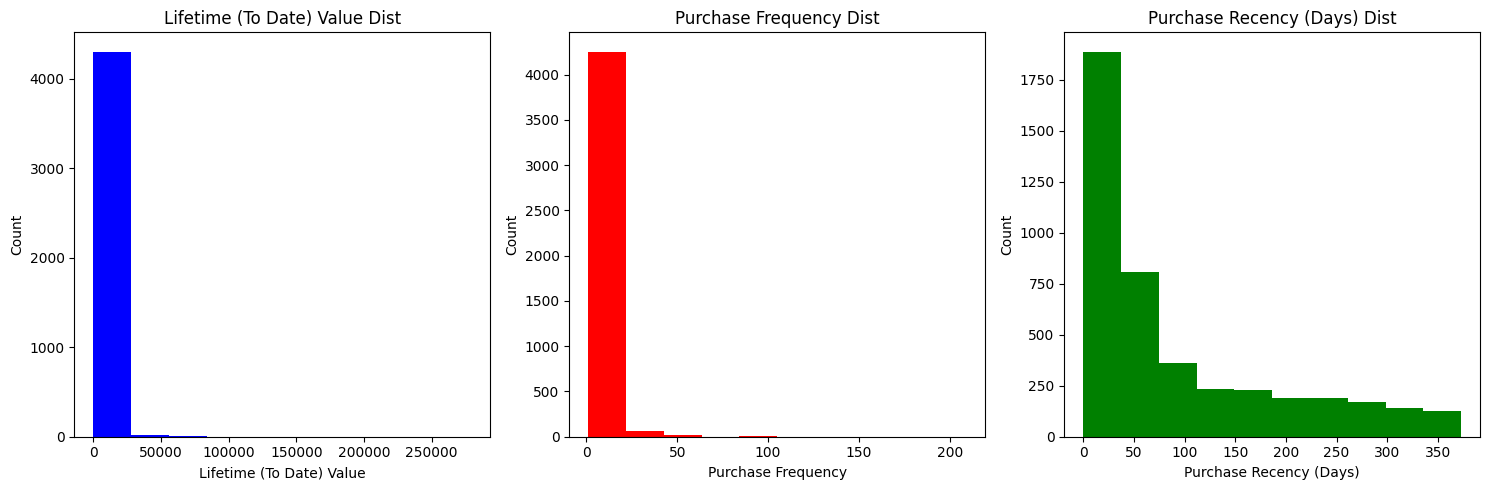

In [70]:
#Look at distributions

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(transactions_by_customer["LTDValue"], color="blue")
plt.title("Lifetime (To Date) Value Dist")
plt.xlabel("Lifetime (To Date) Value")
plt.ylabel("Count")

plt.subplot(1,3,2)
plt.hist(transactions_by_customer["PurchaseFrequency"], color="red")
plt.title("Purchase Frequency Dist")
plt.xlabel("Purchase Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
plt.hist(transactions_by_customer["PurchaseRecencyDays"], color="green")
plt.title("Purchase Recency (Days) Dist")
plt.xlabel("Purchase Recency (Days)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()
#LTDValue and PurchaseFrequency clearly have some outliers

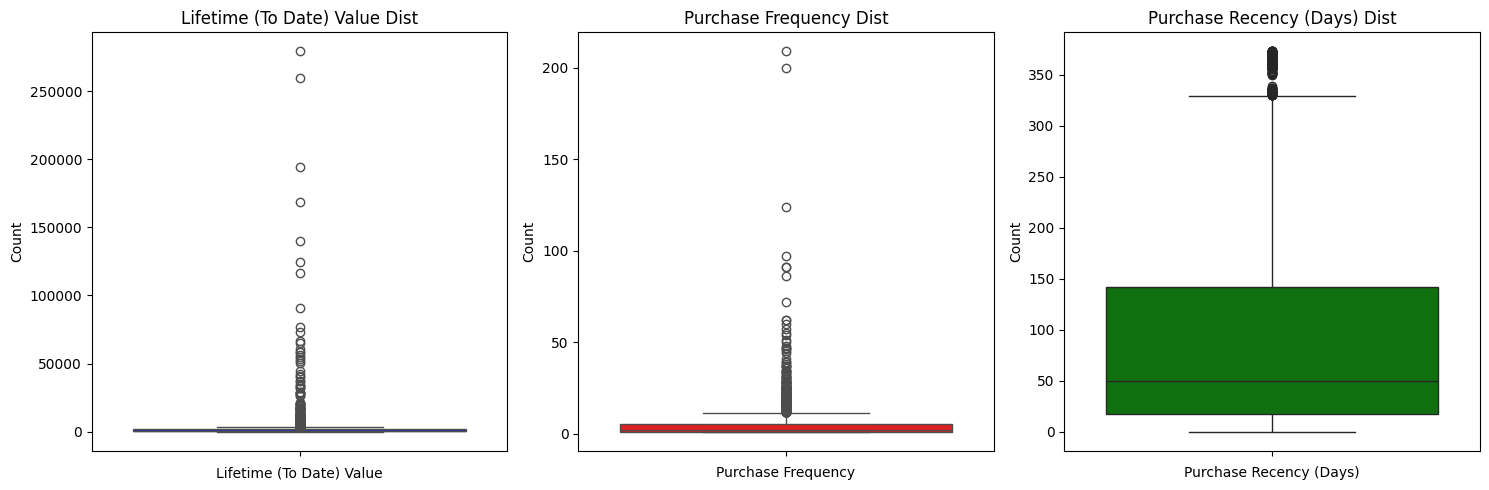

In [73]:
# Look at boxplots
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(transactions_by_customer["LTDValue"], color="blue")
plt.title("Lifetime (To Date) Value Dist")
plt.xlabel("Lifetime (To Date) Value")
plt.ylabel("Count")

plt.subplot(1,3,2)
sns.boxplot(transactions_by_customer["PurchaseFrequency"], color="red")
plt.title("Purchase Frequency Dist")
plt.xlabel("Purchase Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
sns.boxplot(transactions_by_customer["PurchaseRecencyDays"], color="green")
plt.title("Purchase Recency (Days) Dist")
plt.xlabel("Purchase Recency (Days)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Outlier Extraction

In [79]:
#Pull out 1.5 IQR outliers of LTDValue
LTD_q1 = transactions_by_customer["LTDValue"].quantile(0.25)
LTD_q3 = transactions_by_customer["LTDValue"].quantile(0.75)
LTD_iqr = LTD_q3 - LTD_q1
LTD_upper = LTD_q3 + (1.5*LTD_iqr)
LTD_lower = LTD_q1 - (1.5*LTD_iqr)

LTDValue_outliers = transactions_by_customer[(transactions_by_customer["LTDValue"] > LTD_upper) | \
     (transactions_by_customer["LTDValue"] < LTD_lower)]

LTDValue_outliers.describe()

,CustomerID,LTDValue,PurchaseFrequency,MostRecentPurchase,PurchaseRecencyDays
count,417.000000,417.000000,417.000000,417,417.000000
mean,15037.328537,12831.520695,16.880096,2011-11-14 10:37:45.899280640,24.635492
min,12346.000000,3667.360000,1.000000,2010-12-02 15:27:00,0.000000
25%,13319.000000,4448.540000,8.000000,2011-11-15 14:22:00,3.000000
50%,15023.000000,5955.710000,13.000000,2011-11-29 11:48:00,10.000000
75%,16652.000000,9818.820000,19.000000,2011-12-06 12:09:00,23.000000
max,18251.000000,279138.020000,209.000000,2011-12-09 12:49:00,371.000000
std,1796.638737,26357.690274,19.322417,NaN,46.293446


In [82]:
#Pull out 1.5 IQR outliers of PurchaseFrequency
PF_q1 = transactions_by_customer["PurchaseFrequency"].quantile(0.25)
PF_q3 = transactions_by_customer["PurchaseFrequency"].quantile(0.75)
PF_iqr = PF_q3 - PF_q1
PF_upper = PF_q3 + (1.5*PF_iqr)
PF_lower = PF_q1 - (1.5*PF_iqr)

PurchaseFrequency_outliers = transactions_by_customer[(transactions_by_customer["PurchaseFrequency"] > PF_upper) | \
     (transactions_by_customer["PurchaseFrequency"] < PF_lower)]

PurchaseFrequency_outliers.describe()

,CustomerID,LTDValue,PurchaseFrequency,MostRecentPurchase,PurchaseRecencyDays
count,282.000000,282.000000,282.000000,282,282.000000
mean,15348.219858,14430.230816,22.992908,2011-11-25 12:23:52.978723584,13.563830
min,12395.000000,1296.440000,12.000000,2010-12-02 15:27:00,0.000000
25%,13880.250000,4204.672500,13.000000,2011-11-23 20:17:15,2.000000
50%,15294.500000,6322.310000,17.000000,2011-12-02 15:35:00,6.000000
75%,16775.250000,11040.835000,24.750000,2011-12-07 12:02:00,15.000000
max,18283.000000,279138.020000,209.000000,2011-12-09 12:49:00,371.000000
std,1739.533298,29996.070596,21.216222,NaN,30.813949


In [89]:
#Filter out outliers
non_outliers_tbc = transactions_by_customer[(~transactions_by_customer.index.isin(LTDValue_outliers.index))&\
    (~transactions_by_customer.index.isin(PurchaseFrequency_outliers.index))]

non_outliers_tbc.describe()

,CustomerID,LTDValue,PurchaseFrequency,MostRecentPurchase,PurchaseRecencyDays
count,3873.000000,3873.000000,3873.000000,3873,3873.000000
mean,15323.415957,862.135662,2.768913,2011-08-31 08:37:05.964368640,99.656339
min,12348.000000,3.750000,1.000000,2010-12-01 09:53:00,0.000000
25%,13848.000000,279.770000,1.000000,2011-07-03 14:58:00,21.000000
50%,15333.000000,572.810000,2.000000,2011-10-11 15:12:00,58.000000
75%,16796.000000,1196.330000,4.000000,2011-11-17 14:24:00,158.000000
max,18287.000000,3651.970000,11.000000,2011-12-09 12:50:00,373.000000
std,1709.998509,807.336698,2.179815,NaN,101.677550


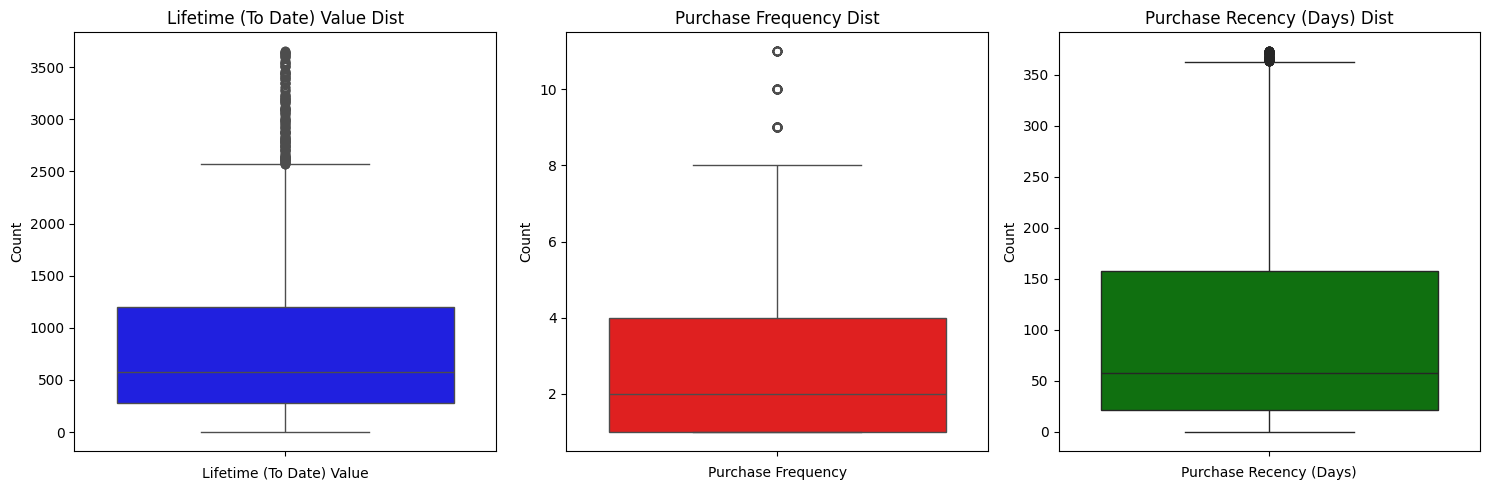

In [90]:
#Remake boxplots
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(non_outliers_tbc["LTDValue"], color="blue")
plt.title("Lifetime (To Date) Value Dist")
plt.xlabel("Lifetime (To Date) Value")
plt.ylabel("Count")

plt.subplot(1,3,2)
sns.boxplot(non_outliers_tbc["PurchaseFrequency"], color="red")
plt.title("Purchase Frequency Dist")
plt.xlabel("Purchase Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
sns.boxplot(non_outliers_tbc["PurchaseRecencyDays"], color="green")
plt.title("Purchase Recency (Days) Dist")
plt.xlabel("Purchase Recency (Days)")
plt.ylabel("Count")

plt.tight_layout()
plt.show() #Way better

## Scaling

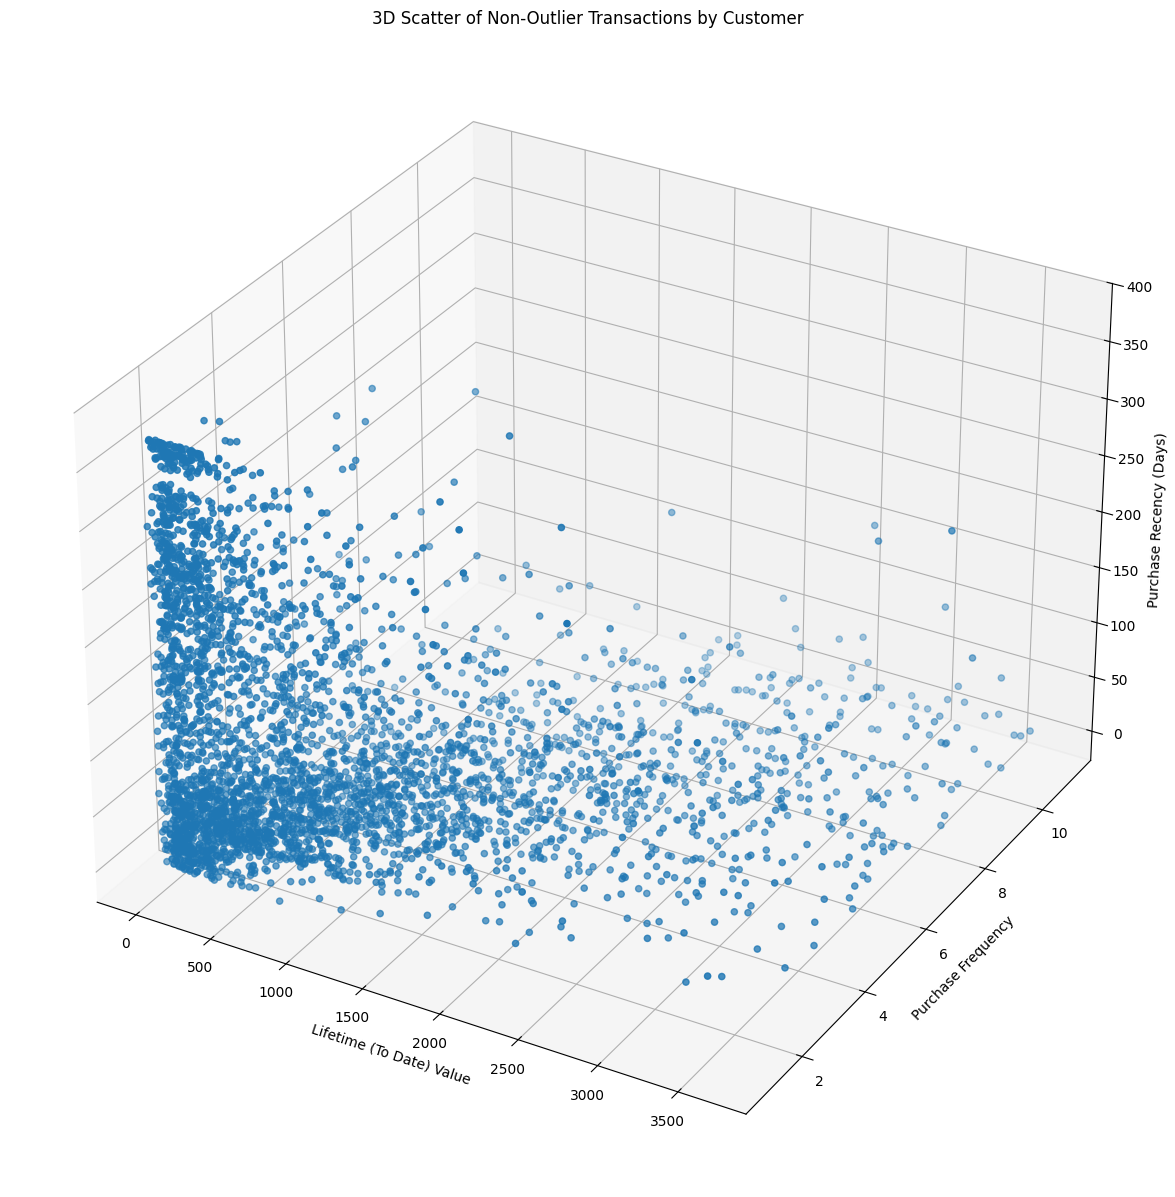

In [97]:
#Graph all three dimensions
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_tbc["LTDValue"], non_outliers_tbc["PurchaseFrequency"], non_outliers_tbc["PurchaseRecencyDays"])

ax.set_xlabel("Lifetime (To Date) Value")
ax.set_ylabel("Purchase Frequency")
ax.set_zlabel("Purchase Recency (Days)")

ax.set_title("3D Scatter of Non-Outlier Transactions by Customer")
plt.show()

In [86]:
#Create 3 groups, high spenders, frequent spenders, and high AND frequent spenders
overlap_idx = LTDValue_outliers.index.intersection(PurchaseFrequency_outliers.index)
LTD_outliers_only = LTDValue_outliers.drop(overlap_idx)
Freq_outliers_only = PurchaseFrequency_outliers.drop(overlap_idx)
LTD_and_Freq_outliers = LTDValue_outliers.loc[overlap_idx]

#Preassign "cluster" values
LTD_outliers_only["Cluster"] = -1
Freq_outliers_only["Cluster"] = -2
LTD_and_Freq_outliers["Cluster"] = -3

In [103]:
scaler = StandardScaler()

scaled_tbc = scaler.fit_transform(non_outliers_tbc.drop(["CustomerID","MostRecentPurchase"], axis=1))

scaled_tbc

array([[ 0.71243955,  0.56483955, -0.252363  ],
       [ 0.73759959, -0.81160146, -0.80319483],
       [-0.70331124, -0.81160146,  2.05916342],
       ...,
       [-0.96789425, -0.81160146,  0.79028296],
       [-0.84744568, -0.35278779, -0.91139394],
       [ 1.20800932,  0.10602588, -0.56712404]])

In [104]:
scaled_tbc_df = pd.DataFrame(scaled_tbc, index=non_outliers_tbc.index,
                             columns=["LTDValue",
                                      "PurchaseFrequency",
                                      "PurchaseRecencyDays"])

scaled_tbc_df

,LTDValue,PurchaseFrequency,PurchaseRecencyDays
2,0.712440,0.564840,-0.252363
3,0.737600,-0.811601,-0.803195
4,-0.703311,-0.811601,2.059163
5,1.689605,2.400094,-0.635978
6,-0.957761,-0.811601,1.016517
...,...,...,...
4331,-0.852587,-0.811601,-0.262199
4332,-0.844287,-0.811601,1.744402
4333,-0.967894,-0.811601,0.790283
4334,-0.847446,-0.352788,-0.911394


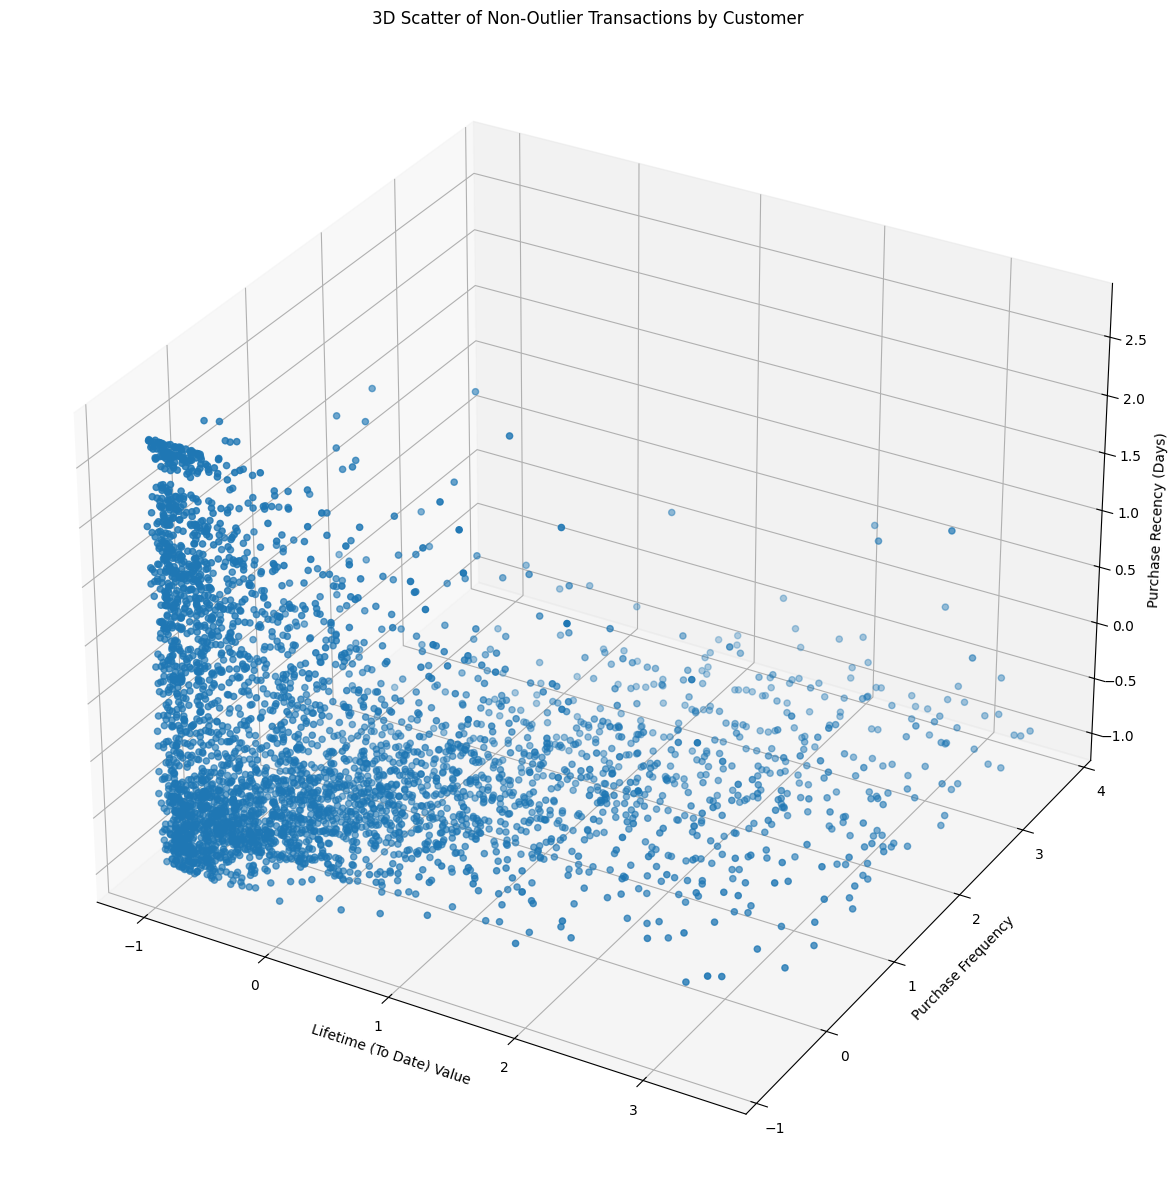

In [105]:
#Plot scaled 3d scatter
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_tbc_df["LTDValue"], scaled_tbc_df["PurchaseFrequency"], scaled_tbc_df["PurchaseRecencyDays"])

ax.set_xlabel("Lifetime (To Date) Value")
ax.set_ylabel("Purchase Frequency")
ax.set_zlabel("Purchase Recency (Days)")

ax.set_title("3D Scatter of Non-Outlier Transactions by Customer")
plt.show()

## Export

In [108]:
scaled_tbc_df.to_csv('../data/scaled_tbc_no_out.csv')
non_outliers_tbc.to_csv('../data/tbc_no_outliers.csv')
LTD_outliers_only.to_csv('../data/LTD_outliers_only.csv')
Freq_outliers_only.to_csv('../data/Freq_outliers_only.csv')
LTD_and_Freq_outliers.to_csv('../data/LTD_and_Freq_outliers_only.csv')